## Model Evaluation

## Script Summary

This script is designed for evaluating a pre-trained deep learning model on a validation dataset. The key steps include:

1. **Configuration Management**: The `ConfigurationManager` class reads configuration and parameter files, creates necessary directories, and provides an `EvaluationConfig` object containing paths and parameters for evaluation.

2. **Model Evaluation**: The `Evaluation` class handles the evaluation process. It:
    - Loads the pre-trained model from the specified path.
    - Prepares a validation data generator with specified image size and batch size.
    - Evaluates the model on the validation dataset and computes the loss and accuracy.

3. **Saving Results**: The evaluation results (loss and accuracy) are saved in a JSON file named `scores.json`.

The script is modular, with reusable components for configuration management, data handling, and evaluation. It ensures that the evaluation process is automated and the results are stored for further analysis.

In [1]:
import os

In [2]:
%pwd

'/home/zkhechadoorian/CNNs_Cats_and_Dogs/research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'/home/zkhechadoorian/CNNs_Cats_and_Dogs'

In [5]:
import tensorflow as tf

2025-09-18 23:10:55.852034: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-18 23:10:55.852485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 23:10:55.918671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-18 23:10:57.664941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [6]:
%pwd

'/home/zkhechadoorian/CNNs_Cats_and_Dogs'

In [7]:
model = tf.keras.models.load_model("artifacts/training/scan_over_freeze_till_models_freeze_6.h5", compile=False)


2025-09-18 23:10:59.190182: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    training_data: Path
    all_params: dict
    params_image_size: list
    params_batch_size: int

In [9]:
from ImageClassification.constants import *
from ImageClassification.utils import read_yaml, create_directories, save_json

In [10]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_validation_config(self) -> EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model="artifacts/training/model.h5",
            training_data="artifacts/data_ingestion/PetImages",
            all_params=self.params,
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )

        return eval_config

In [11]:
from urllib.parse import urlparse

In [12]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    
    def _valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.30
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

    
    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    

    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = self.model.evaluate(self.valid_generator)


    
    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)
        

In [13]:
try:
    config = ConfigurationManager()
    val_config = config.get_validation_config()
    evaluation = Evaluation(val_config)
    evaluation.evaluation()
    evaluation.save_score()

except Exception as e:
   raise e

[2025-09-18 23:10:59,603: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-09-18 23:10:59,606: INFO: common: yaml file: params.yaml loaded successfully]
[2025-09-18 23:10:59,607: INFO: common: created directory at: artifacts]
[2025-09-18 23:10:59,780: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
Found 148 images belonging to 2 classes.


/home/zkhechadoorian/CNNs_Cats_and_Dogs/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.3986 - loss: 0.6935
[2025-09-18 23:11:02,889: INFO: common: json file saved at: scores.json]


In [ ]:
# Loop through all models in the artifacts/training directory and evaluate them
import os

for model_file in os.listdir("artifacts/training"):
    if model_file.endswith(".h5") and "augmented_models" in model_file:
        model_path = os.path.join("artifacts/training", model_file)
        print(f"\n\nEvaluating model: {model_path}")
        val_config = EvaluationConfig(
            path_of_model=model_path,
            training_data="artifacts/data_ingestion/PetImages",
            all_params=config.params,
            params_image_size=config.params.IMAGE_SIZE,
            params_batch_size=config.params.BATCH_SIZE
        )
        evaluation = Evaluation(val_config)
        evaluation.evaluation()
        evaluation.save_score()



Evaluating model: artifacts/training/scan_over_freeze_till_models_freeze_10.h5
[2025-09-18 23:11:03,083: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
Found 148 images belonging to 2 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.6216 - loss: 0.6923
[2025-09-18 23:11:06,145: INFO: common: json file saved at: scores.json]


Evaluating model: artifacts/training/scan_over_freeze_till_models_freeze_2.h5
[2025-09-18 23:11:06,337: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
Found 148 images belonging to 2 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.6149 - loss: 5.2347
[2025-09-18 23:11:09,240: INFO: common: json file saved at: scores.json]


Evaluating model: artifacts/training/scan_over_freeze_til

In [15]:
# set model to freeze_till_4 and evaluate
model = tf.keras.models.load_model("artifacts/training/scan_over_freeze_till_models_freeze_4.h5", compile=False)
model.compile(
    optimizer="sgd", 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)
model.evaluate(evaluation.valid_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8986 - loss: 0.2218


[0.22178222239017487, 0.8986486196517944]

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step


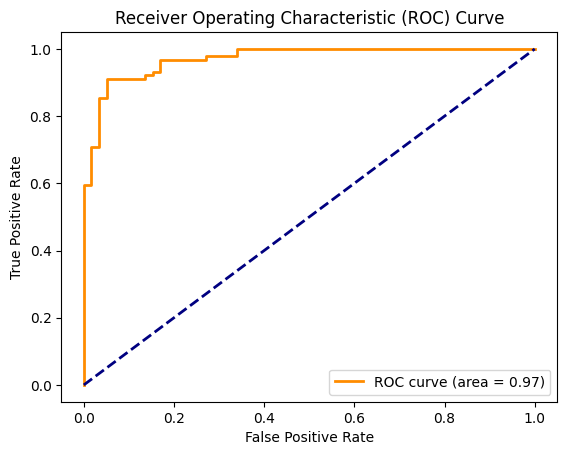

In [16]:
from sklearn.metrics import roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

# Get true labels and predicted probabilities
true_labels = evaluation.valid_generator.classes
predicted_probs = model.predict(evaluation.valid_generator)

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(true_labels, predicted_probs[:, 1])  # Assuming binary classification
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix

A **confusion matrix** is a table used to evaluate the performance of a classification model. It provides a summary of prediction results on a classification problem, showing the number of correct and incorrect predictions broken down by each class. This matrix is especially useful for understanding the performance of a model beyond simple accuracy.

### Structure of a Confusion Matrix

For a binary classification problem, the confusion matrix is a 2x2 table:

|                | Predicted: Positive | Predicted: Negative |
|----------------|---------------------|---------------------|
| **Actual: Positive** | True Positive (TP)      | False Negative (FN)     |
| **Actual: Negative** | False Positive (FP)     | True Negative (TN)      |

- **True Positive (TP)**: The model correctly predicted the positive class.
- **True Negative (TN)**: The model correctly predicted the negative class.
- **False Positive (FP)**: The model incorrectly predicted the positive class (Type I error).
- **False Negative (FN)**: The model incorrectly predicted the negative class (Type II error).

### Metrics Derived from the Confusion Matrix

From the confusion matrix, several performance metrics can be calculated:

1. **Accuracy**: The proportion of correct predictions.
    \[
    \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
    \]

2. **Precision**: The proportion of positive predictions that are correct.
    \[
    \text{Precision} = \frac{TP}{TP + FP}
    \]

3. **Recall (Sensitivity)**: The proportion of actual positives that are correctly identified.
    \[
    \text{Recall} = \frac{TP}{TP + FN}
    \]

4. **F1-Score**: The harmonic mean of precision and recall.
    \[
    F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
    \]

5. **Specificity**: The proportion of actual negatives that are correctly identified.
    \[
    \text{Specificity} = \frac{TN}{TN + FP}
    \]

### How to Interpret a Confusion Matrix

- A high number of **True Positives (TP)** and **True Negatives (TN)** indicates good model performance.
- A high number of **False Positives (FP)** means the model is incorrectly classifying negatives as positives, which can be problematic in scenarios like spam detection.
- A high number of **False Negatives (FN)** means the model is missing positives, which can be critical in scenarios like disease diagnosis.

By analyzing the confusion matrix, you can identify the strengths and weaknesses of your model and make informed decisions to improve its performance.

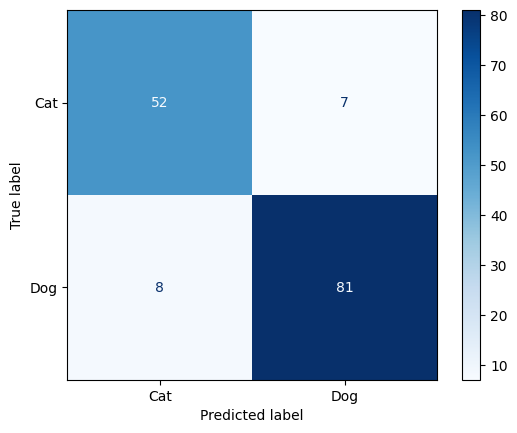

In [17]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(true_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=evaluation.valid_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

The confusion matrix indicates that there are very few images being falsely labeled. The model is performing well. 

### Potential Improvements:
1. **Data Augmentation**: Increase the diversity of cat images in the training dataset by applying data augmentation techniques such as rotation, flipping, zooming, and brightness adjustments. This can help the model generalize better to variations in images and reduce false negatives and false positives.

2. **Class Balancing**: Ensure that the training dataset has a balanced number of cat and dog images. If the dataset is imbalanced, oversample the minority class or undersample the majority class to reduce bias. (This is already true for this dataset.)

3. **Fine-Tuning the Model**: Adjust the model's architecture or hyperparameters, such as learning rate, class weights, or loss function. For example, assigning higher weights to the cat class in the loss function can penalize misclassifications of cats more heavily, encouraging the model to focus on correctly identifying cats.